$$

    f(a) = e^{-\int_0^a{(1+\epsilon(a, s))\mu(s) ds}}\\
    \mu(s) = \mu_{ub} - (\mu_{ub} - \mu_{lb})\frac{s^{m}}{s^{m} + K^{m}}

$$

$$
\epsilon(a, s) = 
\begin{cases}
    0 & \text{if } s < a - t_e \\
    \epsilon_0 e^{-\tau|a-t_e|} e^{-\lambda(t_e-(a-s))} & \text{otherwise }
\end{cases}
$$

In [1]:
from survival_analysis import *
import pandas as pd

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


In [2]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]
sector_params_MLE = dict(zip(sector_list, parameters))

In [ ]:
from one_tail_dip import *
from hill import *
import matplotlib.pyplot as plt

def onetail_dip_model(df_analysis, sector_params_MLE, sector):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess = [0.1, 0.05, 10, 5, find_dip(df_analysis, sector), 3, 1, 0.1]

    result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
    print("Fitted parameters (with dip):")
    print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'AIC with dip = {aic_with_dip} \n AIC original = {aic_original}')
    bic_original = 2 * 4 + np.log(len(ages) * len(survivors)) * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    bic_with_dip = 2 * 8 + np.log(len(ages) * len(survivors)) * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'BIC with dip = {bic_with_dip} \n BIC original = {bic_original}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

    return (aic_with_dip, aic_original), (bic_with_dip, bic_original)

--- Sector G ---
Fitted parameters (with dip):
mu_ub: 0.12726864194112503, mu_lb: 0.03807641459678071, K: 13.71120913748422, m: 4.4862513420005845, t_e: 8.25647560175015, eps0: 7.23507011659395, tau: 1.5283646874049974, lam: 1.5283646874049974
AIC with dip = 395465.4667404475 
 AIC original = 396597.3040134779
BIC with dip = 395545.63690515305 
 BIC original = 396637.3890958306


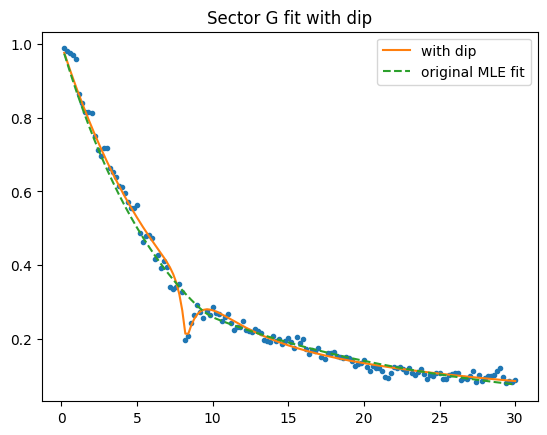

--- Sector H ---
Fitted parameters (with dip):
mu_ub: 0.08957383952818533, mu_lb: 0.001, K: 22.8314305439425, m: 22.749081288010935, t_e: 6.846661431150933, eps0: 2.3618809756875567, tau: 0.5997111550309087, lam: 1.0124037332474174e-05
AIC with dip = 83364.77346243674 
 AIC original = 85957.70099236167
BIC with dip = 83444.94362714229 
 BIC original = 85997.78607471444


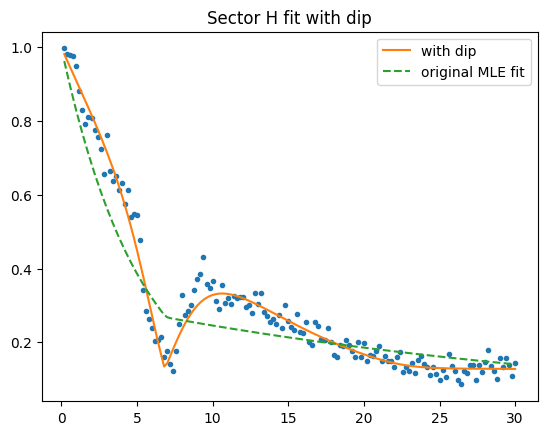

--- Sector S ---
Fitted parameters (with dip):
mu_ub: 0.13575945832518316, mu_lb: 0.00100000000004331, K: 13.471550710726323, m: 5.56094897605973, t_e: 8.27161565431276, eps0: 20.0, tau: 5.338904754844598, lam: 2.992999345020199
AIC with dip = 71390.04937605289 
 AIC original = 71512.57347341714
BIC with dip = 71470.21954075844 
 BIC original = 71552.65855576991


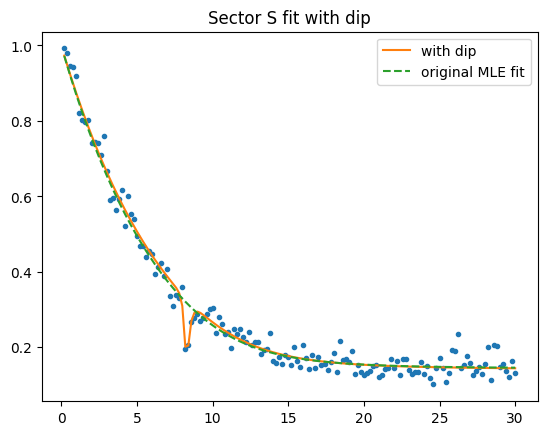

--- Sector J ---
Fitted parameters (with dip):
mu_ub: 0.12386920809591377, mu_lb: 0.05999938747915055, K: 10.708234222907398, m: 20.025989614607692, t_e: 4.539268793101835, eps0: 3.94807446311566, tau: 2.6186694273969437, lam: 1.2959522833249877
AIC with dip = 113661.75510107588 
 AIC original = 113961.26472763256
BIC with dip = 113741.92526578142 
 BIC original = 114001.34980998533


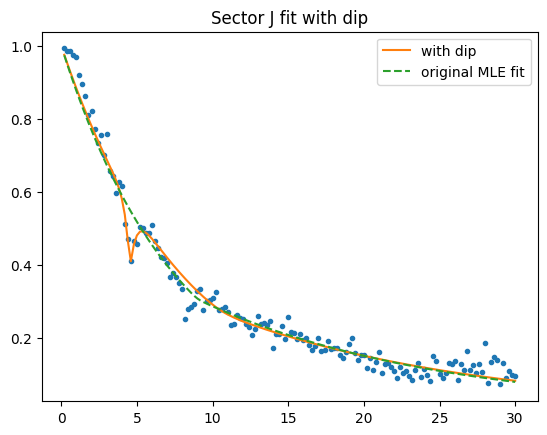

--- Sector M ---
Fitted parameters (with dip):
mu_ub: 0.08602912723274525, mu_lb: 0.001, K: 23.84464012789956, m: 18.818110188658686, t_e: 7.966494691738405, eps0: 0.9944906284146442, tau: 0.19651001121782555, lam: 0.1965100111983791
AIC with dip = 213206.91659917575 
 AIC original = 213792.9742091233
BIC with dip = 213287.0867638813 
 BIC original = 213833.05929147606


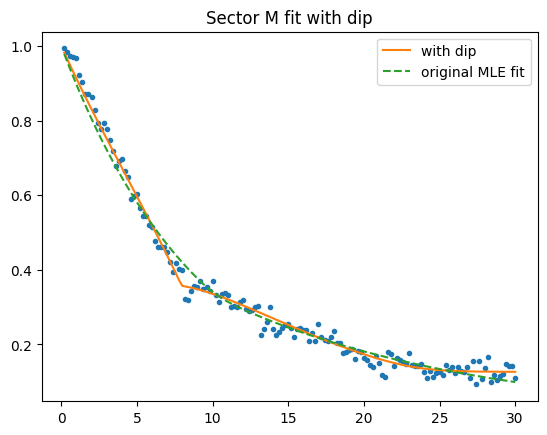

--- Sector I ---
Fitted parameters (with dip):
mu_ub: 0.124435319584067, mu_lb: 0.0010000000000000072, K: 20.894230527407018, m: 4.547079200816678, t_e: 5.199953232413778, eps0: 3.028887224422073, tau: 2.5726864703655052, lam: 2.5726864703655004
AIC with dip = 68490.03635116188 
 AIC original = 68503.12634688056
BIC with dip = 68570.20651586742 
 BIC original = 68543.21142923333


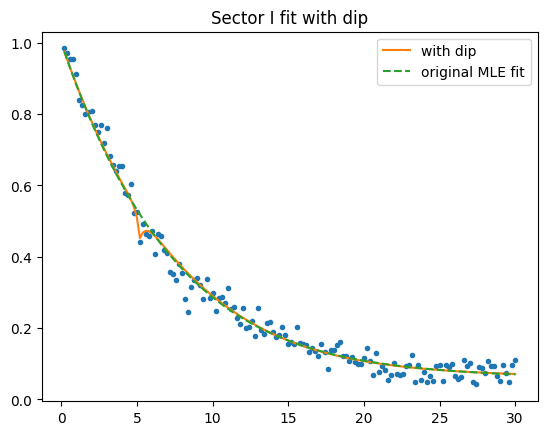

In [4]:
test_list = ['G', 'H', 'S', 'J', 'M', 'I']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in test_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])  
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])  

In [5]:
aic_series = pd.Series(dict(zip(test_list, aic_dip_list)), index=test_list)
aic_original_series = pd.Series(dict(zip(test_list, aic_original_list)), index=test_list)
# Join the two series into a DataFrame
aic_df = pd.DataFrame({'AIC with Dip': aic_series, 'AIC Original': aic_original_series})
print(aic_df)

    AIC with Dip   AIC Original
G  395465.466740  396637.389096
H   83364.773462   85997.786075
S   71390.049376   71552.658556
J  113661.755101  114001.349810
M  213206.916599  213833.059291
I   68490.036351   68543.211429


In [6]:
bic_series = pd.Series(dict(zip(test_list, bic_dip_list)), index=test_list)
bic_original_series = pd.Series(dict(zip(test_list, bic_original_list)), index=test_list)
# Join the two series into a DataFrame
bic_df = pd.DataFrame({'BIC with Dip': bic_series, 'BIC Original': bic_original_series})
print(bic_df)

    BIC with Dip   BIC Original
G  395545.636905  396637.389096
H   83444.943627   85997.786075
S   71470.219541   71552.658556
J  113741.925266  114001.349810
M  213287.086764  213833.059291
I   68570.206516   68543.211429


--- Sector F ---
Fitted parameters (with dip):
mu_ub: 0.07758775241525354, mu_lb: 0.07758775142046728, K: 12.962010102564422, m: 2.4169909726840273, t_e: 5.379966009625431, eps0: 1.4757633354459083, tau: 1.1468262539878342, lam: 0.8757146546779027
AIC with dip = 95554.70272850509 
 AIC original = 95571.32745895388
BIC with dip = 95634.87289321063 
 BIC original = 95611.41254130665


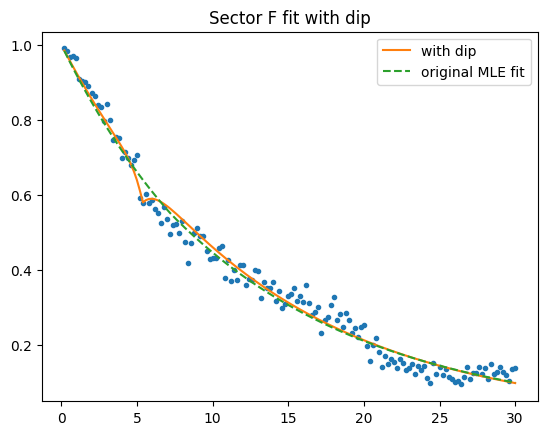

--- Sector P ---


c:\Users\chong\OneDrive\Documents\GitHub\a-star\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.0887121228462275, mu_lb: 0.08871211584505052, K: 12.969166788178102, m: 0.5, t_e: 8.239774810848505, eps0: 0.9638251753537213, tau: 0.13557699225545305, lam: 0.13557699246658733
AIC with dip = 50220.202895297596 
 AIC original = 50319.80915009245
BIC with dip = 50300.373060003134 
 BIC original = 50359.89423244522


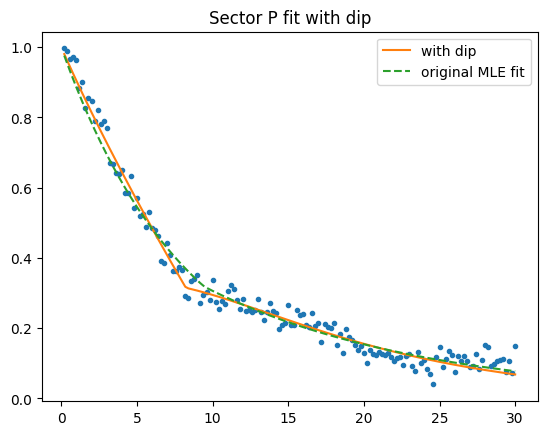

--- Sector K ---


c:\Users\chong\OneDrive\Documents\GitHub\a-star\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.06633747495923505, mu_lb: 0.0010000000736666676, K: 20.09139759342859, m: 12.865350460735424, t_e: 7.677663296749926, eps0: 0.6964784050896804, tau: 0.37091607798312526, lam: 0.3709160989053461
AIC with dip = 112363.6502826821 
 AIC original = 112433.7547534963
BIC with dip = 112443.82044738764 
 BIC original = 112473.83983584907


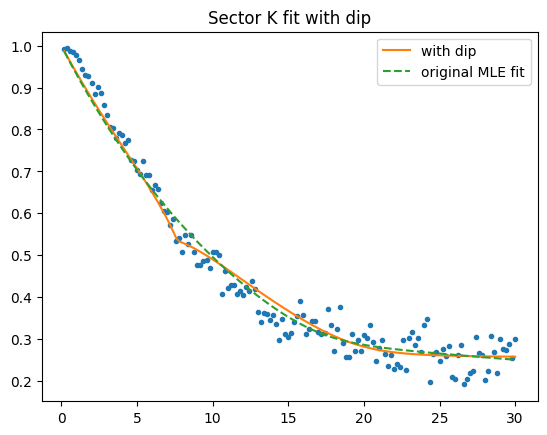

In [7]:
test_list = ['F', 'P', 'K']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in test_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])

In [8]:
aic_series = pd.Series(dict(zip(test_list, aic_dip_list)), index=test_list)
aic_original_series = pd.Series(dict(zip(test_list, aic_original_list)), index=test_list)
# Join the two series into a DataFrame
aic_df = pd.DataFrame({'AIC with Dip': aic_series, 'AIC Original': aic_original_series})
print(aic_df)

bic_series = pd.Series(dict(zip(test_list, bic_dip_list)), index=test_list)
bic_original_series = pd.Series(dict(zip(test_list, bic_original_list)), index=test_list)
# Join the two series into a DataFrame
bic_df = pd.DataFrame({'BIC with Dip': bic_series, 'BIC Original': bic_original_series})
print(bic_df)

    AIC with Dip   AIC Original
F   95554.702729   95611.412541
P   50220.202895   50359.894232
K  112363.650283  112473.839836
    BIC with Dip   BIC Original
F   95634.872893   95611.412541
P   50300.373060   50359.894232
K  112443.820447  112473.839836


In [6]:
from hill import *
import numpy as np
from scipy.integrate import quad
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def epsilon(s, a, eps0, tau, lam, t_e):
    '''
    Time-dependent perturbation function
    Inputs:
    - s: integration variable (time)
    - a: age
    - eps0: amplitude of the perturbation
    - tau: decay rate (against age of firm) of the effect of external event
    - lam: recovery rate (against time since event)
    - t_e: time of event causing the perturbation
    '''
    def g(a, eps0, tau, t_e):
        if a < t_e:
            return eps0
        else:
            return eps0 * np.exp(-abs(a - t_e) * tau)
    if s < a - t_e:
        return 0
    else:
        return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam):
    val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)
    return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam) for a in ages])

def find_dip(df_analysis, sector):
    '''
    Find the dip location for a given sector by finding points of minimum log-likelihood
    '''
    sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
    parameters = [
        [0.13660027, 0.03574423, 12.39113424, 4.14356328],
        [0.10877533, 0.0418096, 12.55269306, 4.41391222],
        [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
        [0.13090805, 0.03791174, 11.9429807, 4.05657508],
        [0.070120134, 0.011071032, 17.60063205, 11.71975389],
        [0.10301031, 0.04128293, 9.26045477, 8.13925264],
        [0.190143914, 0.028016019, 6.93767599, 100],
        [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
        [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
        [0.12568692, 0.03447114, 17.44283135, 5.60609428],
        [0.121213526, 0.068684245, 9.44518567, 100],
        [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
        [0.078301599, 0.047197935, 7.79197632, 100],
        [0.132289514, 0.085485775, 8.85732298, 100]
    ]
    sector_params_MLE = dict(zip(sector_list, parameters))

    _, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    mu_ub, mu_lb, K, m = sector_params_MLE[sector]
    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = survivors * np.log(S_vals) + deaths * np.log(1 - S_vals)

    minlogL_ages = ages[np.argsort(logL)[:9]]
    max_count = 0
    best_cluster = []

    for i in range(len(minlogL_ages)):
        # Find all points within window of minlogL_ages[i]
        cluster = minlogL_ages[(minlogL_ages >= minlogL_ages[i]) & (minlogL_ages <= minlogL_ages[i] + 0.5)]
        if len(cluster) > max_count:
            max_count = len(cluster)
            best_cluster = cluster

    return float(np.mean(best_cluster)) if len(best_cluster) > 0 else None

def neg_ll_hill_with_dip(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = params
    ll = 0
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0 or eps0 < 0 or tau <= 0 or lam <= 0:
        return np.inf

    S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

def mlefit_hill_with_dip(ages, survivors, totals, initial_guess=[0.1, 0.05, 10, 5, 7, 1, 1, 1]):
    '''
    Fit the Hill model with dip using MLE.
    '''
    bounds = [
        (0.01, 0.3),   # mu_ub
        (10e-6, 0.15),   # mu_lb
        (0.1, 30),     # K
        (0.5, 50),    # m
        (3, 10),      # t_e
        (0, 20),    # eps0
        (0.01, 15),      # tau
        (10e-6, 15)      # lam
    ]

    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - x[1]},  # mu_ub - mu_lb > 0
        # {'type': 'ineq', 'fun': lambda x: x[6] - x[7]},  # tau - lam > 0
    ]

    result = minimize(
        neg_ll_hill_with_dip,
        initial_guess,
        args=(ages, survivors, totals),
        bounds=bounds,
        constraints=constraints
    )

    return result

def onetail_dip_model(df_analysis, sector_params_MLE, sector):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess = [0.1, 0.03, 10, 5, find_dip(df_analysis, sector), 3, 1, 1]

    result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
    print("Fitted parameters (with dip):")
    print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'AIC with dip = {aic_with_dip} \n AIC original = {aic_original}')
    bic_original = 2 * 4 + np.log(len(ages) * len(survivors)) * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    bic_with_dip = 2 * 8 + np.log(len(ages) * len(survivors)) * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'BIC with dip = {bic_with_dip} \n BIC original = {bic_original}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

    return (aic_with_dip, aic_original), (bic_with_dip, bic_original)

--- Sector G ---
Fitted parameters (with dip):
mu_ub: 0.12583121864078886, mu_lb: 0.024555158044043766, K: 15.547195409312558, m: 3.6406857434391893, t_e: 8.211310316297913, eps0: 8.743215289200746, tau: 1.039905759043535, lam: 2.1054596121981226
AIC with dip = 395474.2255415766 
 AIC original = 396597.3040134779
BIC with dip = 395554.3957062822 
 BIC original = 396637.3890958306


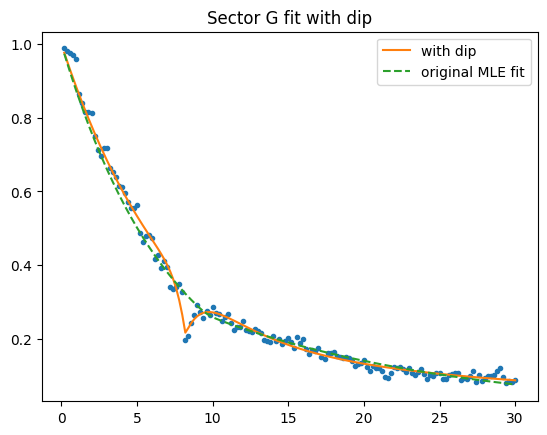

--- Sector M ---
Fitted parameters (with dip):
mu_ub: 0.08120023583801077, mu_lb: 0.007251281852279118, K: 24.617398070024066, m: 50.0, t_e: 8.282369509778128, eps0: 1.715481091625146, tau: 0.11315102519117458, lam: 0.3548071714088561
AIC with dip = 213215.34099206983 
 AIC original = 213792.9742091233
BIC with dip = 213295.51115677538 
 BIC original = 213833.05929147606


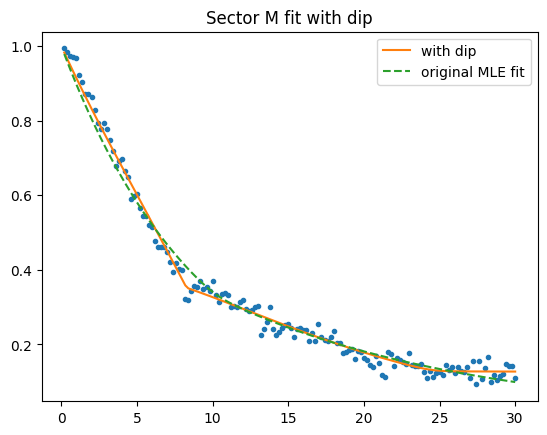

--- Sector F ---
Fitted parameters (with dip):
mu_ub: 0.07804362536169461, mu_lb: 0.07804362535995633, K: 8.538307742219258, m: 3.3188025481162193, t_e: 6.933307903622346, eps0: 4.6563680064439215, tau: 0.550681563165002, lam: 2.850710864738144
AIC with dip = 95545.53641769488 
 AIC original = 95571.32745895388
BIC with dip = 95625.70658240042 
 BIC original = 95611.41254130665


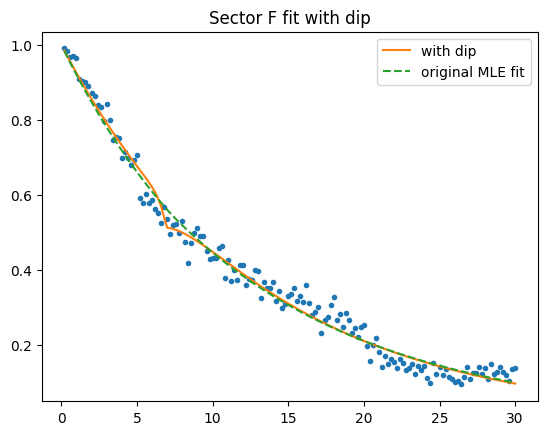

--- Sector J ---
Fitted parameters (with dip):
mu_ub: 0.1238152481019761, mu_lb: 0.05998858106178322, K: 10.719343784888595, m: 20.090324025791276, t_e: 4.622294883530253, eps0: 8.541356823746273, tau: 3.036809452776232, lam: 2.988110496455538
AIC with dip = 113665.40104198988 
 AIC original = 113961.26472763256
BIC with dip = 113745.57120669543 
 BIC original = 114001.34980998533


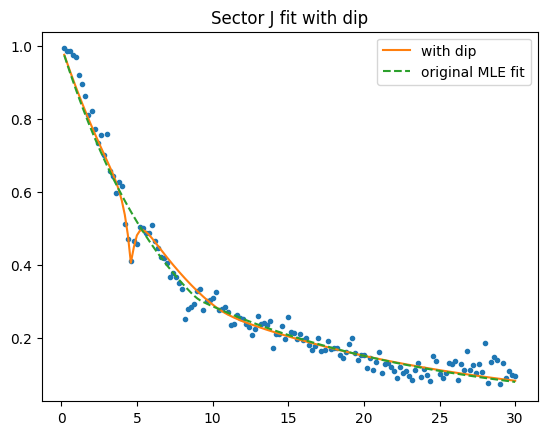

--- Sector K ---
Fitted parameters (with dip):
mu_ub: 0.049938263550921666, mu_lb: 0.017313008537113123, K: 21.497214516705814, m: 29.58615360056818, t_e: 8.450168004523942, eps0: 2.5207931163455957, tau: 0.010000000273034503, lam: 0.42703300760223223
AIC with dip = 112128.26549632451 
 AIC original = 112433.7547534963
BIC with dip = 112208.43566103006 
 BIC original = 112473.83983584907


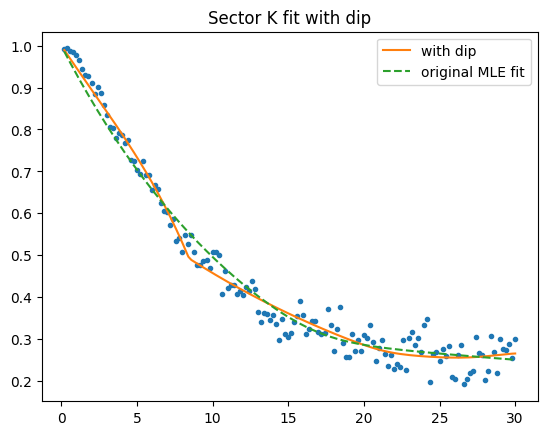

--- Sector C ---


C:\Users\chong\AppData\Local\Temp\ipykernel_15980\1774621938.py:30: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.07960924311446119, mu_lb: 0.05334131337420238, K: 12.991622846508537, m: 19.463489644064666, t_e: 8.286706927031943, eps0: 1.140394351469855, tau: 0.33382392533103133, lam: 0.3100613598001935
AIC with dip = 79037.48972055476 
 AIC original = 79079.07595998689
BIC with dip = 79117.6598852603 
 BIC original = 79119.16104233966


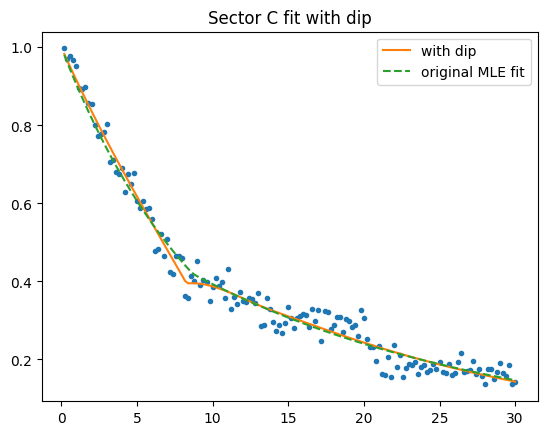

--- Sector H ---
Fitted parameters (with dip):
mu_ub: 0.09425105690260697, mu_lb: 1.0000000000000382e-05, K: 22.13882636092639, m: 6.29825732484015, t_e: 7.2723511174827795, eps0: 10.35366435817044, tau: 1.2639033946011744, lam: 0.6230600745118199
AIC with dip = 83292.14561373722 
 AIC original = 85957.70099236167
BIC with dip = 83372.31577844276 
 BIC original = 85997.78607471444


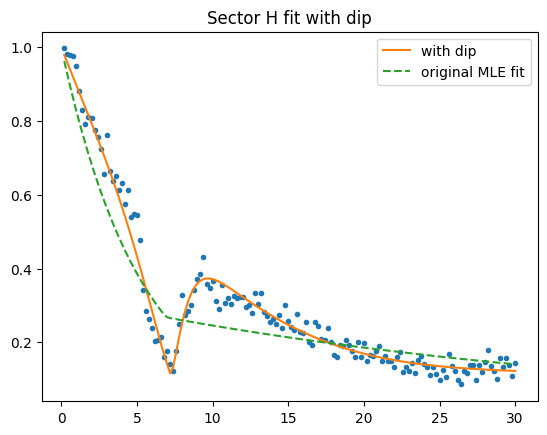

--- Sector S ---


C:\Users\chong\AppData\Local\Temp\ipykernel_15980\1774621938.py:30: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.13512843737806515, mu_lb: 1e-05, K: 13.611942723833605, m: 5.560398226026922, t_e: 8.307950063529294, eps0: 20.0, tau: 4.036709348614262, lam: 4.220309573029555
AIC with dip = 71396.26169531269 
 AIC original = 71512.57347341714
BIC with dip = 71476.43186001823 
 BIC original = 71552.65855576991


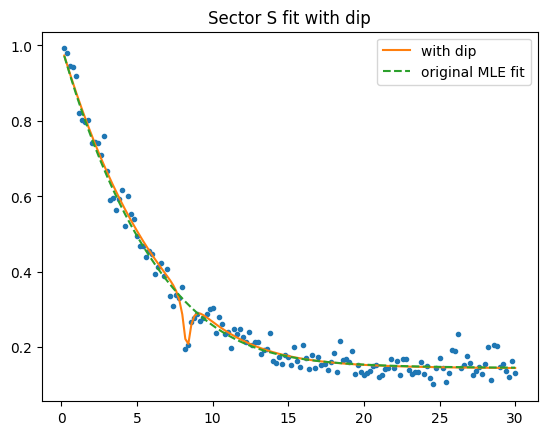

--- Sector N ---
Fitted parameters (with dip):
mu_ub: 0.10539801044344155, mu_lb: 1.0000000000033022e-05, K: 19.763854107826237, m: 50.0, t_e: 8.378062266657034, eps0: 2.256446343661321, tau: 0.9898837050203679, lam: 0.5611938173664219
AIC with dip = 73822.64271754009 
 AIC original = 74032.64426434244
BIC with dip = 73902.81288224563 
 BIC original = 74072.72934669521


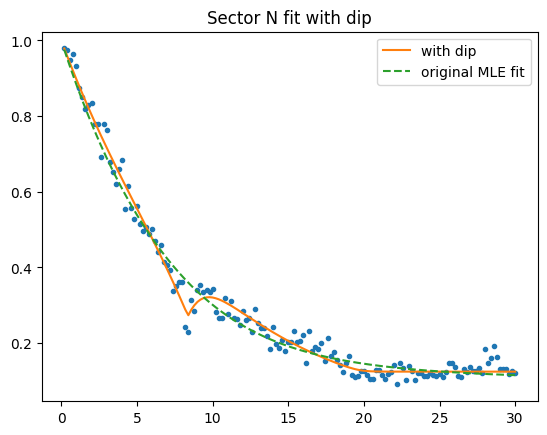

--- Sector I ---


C:\Users\chong\AppData\Local\Temp\ipykernel_15980\1774621938.py:30: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.10328153110493397, mu_lb: 0.009637298924261677, K: 22.972552722155893, m: 45.19495818637223, t_e: 6.167738825631379, eps0: 1.1535026891840443, tau: 0.010000081409894246, lam: 0.49460929303670953
AIC with dip = 68441.12321656944 
 AIC original = 68503.12634688056
BIC with dip = 68521.29338127498 
 BIC original = 68543.21142923333


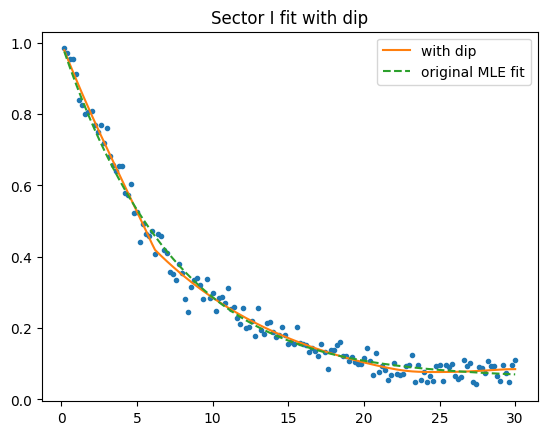

--- Sector P ---


C:\Users\chong\AppData\Local\Temp\ipykernel_15980\1774621938.py:30: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.08765386585836209, mu_lb: 0.08582184069749207, K: 18.074355461881837, m: 6.381743522172156, t_e: 8.24594456253993, eps0: 1.6712141982340605, tau: 0.12158440085784396, lam: 0.3194646467819271
AIC with dip = 50221.5666842988 
 AIC original = 50319.80915009245
BIC with dip = 50301.73684900434 
 BIC original = 50359.89423244522


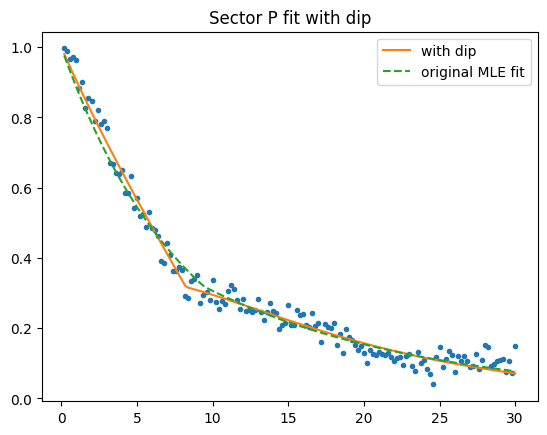

--- Sector L ---
Fitted parameters (with dip):
mu_ub: 0.07338826651648432, mu_lb: 1.0000000000000006e-05, K: 26.04155687542836, m: 50.0, t_e: 7.58145638875932, eps0: 6.869666031150667, tau: 8.620039391273584, lam: 1.6920019600267104
AIC with dip = 23832.4838382161 
 AIC original = 23866.308678079025
BIC with dip = 23912.65400292164 
 BIC original = 23906.393760431794


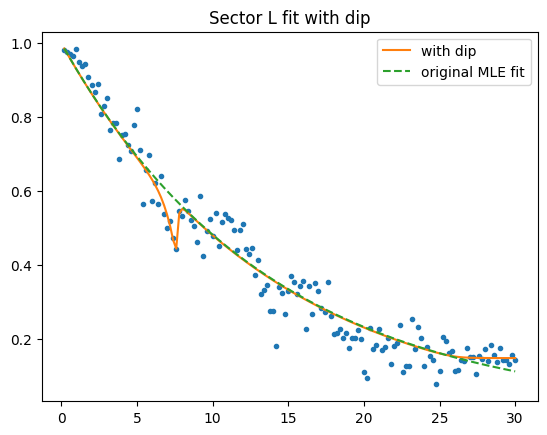

--- Sector Q ---
Fitted parameters (with dip):
mu_ub: 0.06552177380213187, mu_lb: 0.050886939345994794, K: 11.728004251671454, m: 50.0, t_e: 8.608948549411295, eps0: 1.077442186712377, tau: 1.892192002674853, lam: 0.32068192387146305
AIC with dip = 25768.074896916238 
 AIC original = 25785.16168086943
BIC with dip = 25848.24506162178 
 BIC original = 25825.2467632222


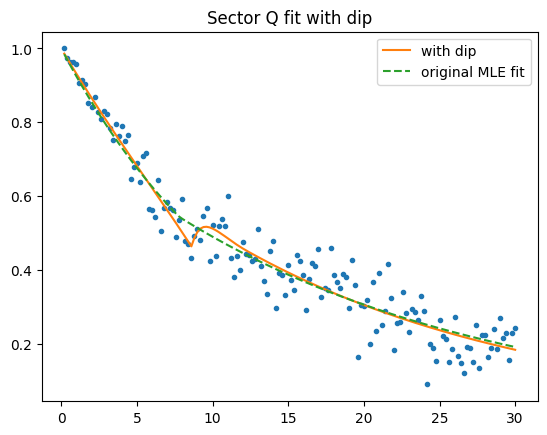

--- Sector R ---


C:\Users\chong\AppData\Local\Temp\ipykernel_15980\1774621938.py:30: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.09317661831366685, mu_lb: 0.09317661831322756, K: 12.72061757101872, m: 6.862977911445478, t_e: 4.870433319416079, eps0: 2.9382869208689315, tau: 0.010000000000000002, lam: 0.8325238415257612
AIC with dip = 15018.932062787724 
 AIC original = 15047.29190333227
BIC with dip = 15099.102227493264 
 BIC original = 15087.376985685041


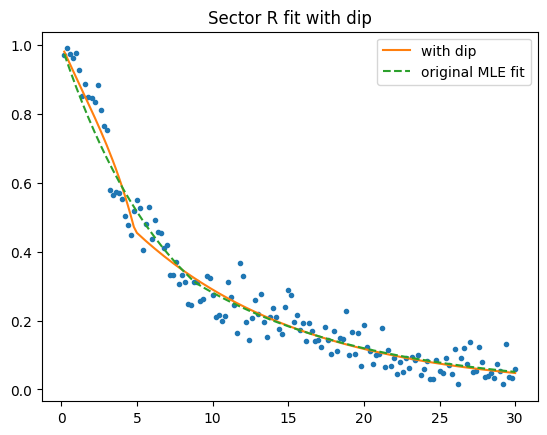

In [7]:
# test_list = ['G', 'H', 'S', 'J', 'M', 'I']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in sector_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])  
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])

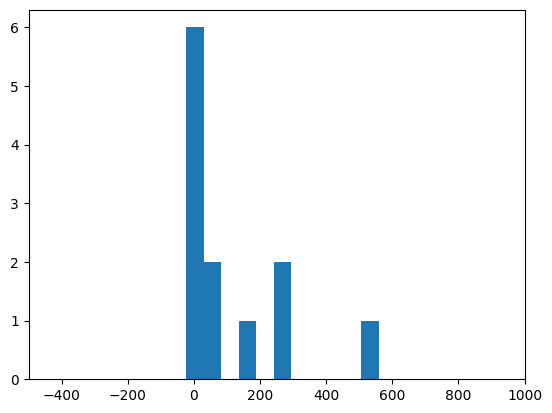

   Sector     AIC diff     BIC diff
0       G  1163.163554  1082.993390
1       M   617.718299   537.548135
2       F    65.876124   -14.294041
3       J   335.948768   255.778603
4       K   345.574340   265.404175
5       C    81.671322     1.501157
6       H  2705.640461  2625.470296
7       S   156.396860    76.226696
8       N   250.086629   169.916464
9       I   102.088213    21.918048
10      P   138.327548    58.157383
11      L    73.909922    -6.260242
12      Q    57.171866   -22.998298
13      R    68.444923   -11.725242


In [ ]:
diff_list = np.array(bic_original_list)-np.array(bic_dip_list)
plt.hist(diff_list, bins=50, label='BIC difference')
plt.xlim(-500, 1000)
plt.show()

table = pd.DataFrame({
    'Sector': sector_list,
    'AIC diff': np.array(aic_original_list) - np.array(aic_dip_list),
    'BIC diff': np.array(bic_original_list) - np.array(bic_dip_list)
})
print(table)

# J v.s. K
# S is the cut-off, exception of K